<a href="https://colab.research.google.com/github/rodrigo103/AprendizajeAutomatico/blob/main/TP1_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Librerías de análisis de datos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas.api.types import CategoricalDtype

from pandas.plotting import scatter_matrix

from pprint import pprint

In [3]:
# Librerías de Machine Learning

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("drive/MyDrive/AprendizajeAutomatico/OnlineNewsPopularity.csv", sep=', ') # agregué el espacio, se estaban parceando con un espacio las keys

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Se separa el dataframe en features (X) y target (y)

In [6]:
features = [
    'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    'average_token_length', 
    'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

X = df[features]
y = df.shares

Lo primero que hay que hacer es separar un conjunto de datos para test

In [7]:
trainval_X, test_X, trainval_y, test_y = train_test_split(X, y, random_state = 0, test_size = 0.3)

Ahora separo el conjunto de datos restante (trainval) en entrenamiento (train) y validación (val)

In [8]:
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, random_state = 0)

Relizo un entrenamiento con varios modelos sin realizar ningun tratamiento sobre los datos para establecer una linea de base

In [9]:
scoring = {
    'neg_mean_absolute_error', 'neg_root_mean_squared_error'
}

preprocessor = ColumnTransformer(
    [
      ('power_transformer', PowerTransformer(), 
        [
          'num_hrefs',
          'num_self_hrefs',
          'n_tokens_content',
          'self_reference_min_shares', 
          'self_reference_max_shares', 
          'self_reference_avg_sharess',
        ]
      ),
      ('standard_scaler', StandardScaler(), 
        [
          # 'n_tokens_title',
          'global_subjectivity', 
          'global_sentiment_polarity',
          'global_rate_positive_words', 
          'global_rate_negative_words',
          'rate_positive_words',
          'rate_negative_words',
          'avg_positive_polarity'
        ]
      ),
    ], remainder='passthrough')

In [36]:
# Funcion para comparar distintos modelos
def score_model(model, preprocessor, X_t, X_v, y_t, y_v, scoring, fit_params):
    my_pipeline = Pipeline(steps=[ 
            ('standard_scaler', preprocessor),
            ('model', model)
        ])

    scores = cross_validate(my_pipeline, 
                            X_t, y_t, 
                            cv = 5, 
                            scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                            fit_params = fit_params)

    mae_score = -1*scores['test_neg_mean_absolute_error'].mean()
    mse_score = -1*scores['test_neg_root_mean_squared_error'].mean()
    
    return mae_score, mse_score


models = [
    # RandomForestRegressor(random_state=1)
    # RandomForestRegressor(n_estimators=50, random_state=1),
    # RandomForestRegressor(n_estimators=100, random_state=1),
    # # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=1),
    # # RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=1),
    # # RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1),
    {'model': XGBRegressor(), 'fit_params': None},
    {'model': XGBRegressor(n_estimators=500), 'fit_params': None},
    # {'model': XGBRegressor(n_estimators=500), 'fit_params': {
    #     'model__early_stopping_rounds':5, 
    #     'model__eval_set':[(val_X, val_y)],
    #     'model__verbose':False
    #     }
    #  },
    {'model': XGBRegressor(n_estimators=1000, learning_rate=0.05), 'fit_params': None},
]

for i in range(0, len(models)):
    mae, mse = score_model(
            model=models[i]['model'],
            preprocessor=preprocessor,
            X_t=train_X, 
            X_v=val_X, 
            y_t=train_y, 
            y_v=val_y,
            scoring=scoring,
            fit_params=models[i]['fit_params']
        )
    print("Model %d MAE: %r MSE: %r" % (i+1, mae, mse))

[22:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 1 MAE: 3256.099848701986 MSE: 13170.125366484814
[22:51:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:52:36] WARNING: /workspace/src/objective/regression_

In [41]:
dt_params = {
  'model__max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 500, 5000],
  'model__random_state': [1]
}

model = DecisionTreeRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline, 
                              dt_params, 
                              cv = 5, 
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);

ValueError: ignored

In [32]:
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__max_leaf_nodes'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__max_leaf_nodes', 'param_model__random_state', 'params', 'split0_test_neg_root_mean_squared_error', 'split1_test_neg_root_mean_squared_error', 'split2_test_neg_root_mean_squared_error', 'split3_test_neg_root_mean_squared_error', 'split4_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'split0_train_neg_root_mean_squared_error', 'split1_train_neg_root_mean_squared_error', 'split2_train_neg_root_mean_squared_error', 'split3_train_neg_root_mean_squared_error', 'split4_train_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error', 'std_train_neg_root_mean_squared_error', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'mean_test_neg

In [18]:
dt_params = {
  'model__n_estimators': [
      # 5, 10, 15, 
      # 20, 25, 50, 100, 
      500, 
      # 1000
      ],
  # 'model__learning_rate': [0.01, 0.05, 0.1],
  # 'model__early_stopping_rounds':[5],
  # 'model__random_state': [1], 
}

model = XGBRegressor()

my_pipeline = Pipeline(steps=[ 
    ('standard_scaler', preprocessor),
    ('model', model)])

grid_pipeline = GridSearchCV(my_pipeline, 
                              dt_params, 
                              cv = 5, 
                              scoring = scoring,
                              refit='neg_mean_absolute_error',
                              return_train_score=True)

grid_pipeline.fit(train_X, train_y);

[03:58:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:59:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:59:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
print(grid_pipeline.cv_results_.keys())

print(grid_pipeline.cv_results_['param_model__n_estimators'].data)

print(grid_pipeline.cv_results_["mean_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_test_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_test_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.cv_results_["mean_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["std_train_neg_mean_absolute_error"][grid_pipeline.best_index_])
print(grid_pipeline.cv_results_["mean_train_neg_root_mean_squared_error"][grid_pipeline.best_index_])

print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__n_estimators', 'params', 'split0_test_neg_root_mean_squared_error', 'split1_test_neg_root_mean_squared_error', 'split2_test_neg_root_mean_squared_error', 'split3_test_neg_root_mean_squared_error', 'split4_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'split0_train_neg_root_mean_squared_error', 'split1_train_neg_root_mean_squared_error', 'split2_train_neg_root_mean_squared_error', 'split3_train_neg_root_mean_squared_error', 'split4_train_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error', 'std_train_neg_root_mean_squared_error', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'mean_test_neg_mean_absolute_error', 'std_tes

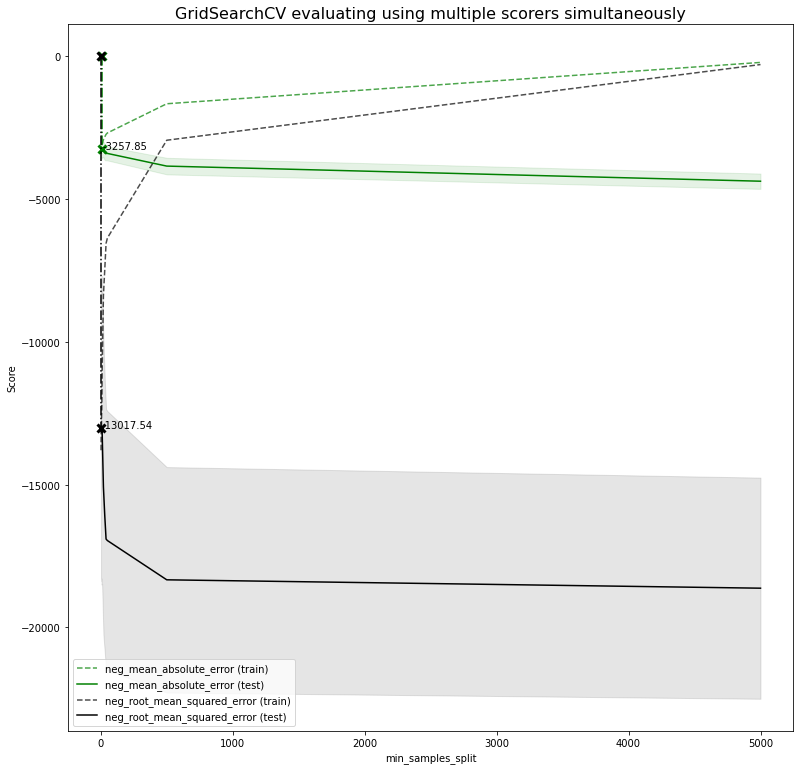

In [34]:
results = grid_pipeline.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0, 550)
# ax.set_ylim(-5000, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_model__max_leaf_nodes"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

Excluyo las noticias con mas de 40000 compartidas del dataframe

In [ ]:
# df = df[df.shares < 40000]

Esto que hice esta mal, lo que hay que hacer es esto mismo pero sobre train_X y train_y

Vuelvo a correr los modelos para observar si hay alguna mejora

In [ ]:
features = [
    'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    'average_token_length', 
    'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

X = df[features]
y = df.shares

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

train_X['shares'] = train_y
train_X = train_X[train_X.shares < 40000]
train_y = train_X.shares
train_X = train_X[features]

In [ ]:
# Funcion para comparar distintos modelos
def score_model(model, X_t=train_X, X_v=val_X, y_t=train_y, y_v=val_y):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds), mean_squared_error(y_v, preds)

models = [
    DecisionTreeRegressor(max_leaf_nodes=None, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=2, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=3, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=4, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=6, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=7, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=8, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=9, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=10, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=20, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=30, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=40, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=50, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=500, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5000, random_state=1),
#     RandomForestRegressor(random_state=1)
#     RandomForestRegressor(n_estimators=50, random_state=1),
#     RandomForestRegressor(n_estimators=100, random_state=1),
#     # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=1),
#     # RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=1),
#     # RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1),
    XGBRegressor(), 
    XGBRegressor(n_estimators=500), 
    XGBRegressor(n_estimators=1000, learning_rate=0.05),
]

for i in range(0, len(models)):
    mae, mse = score_model(models[i])
    print("Model %d MAE: %d MSE: %d" % (i+1, mae, mse))

# Pruebo usando early stopping
my_model2 = XGBRegressor(n_estimators=500)
my_model2.fit(train_X, train_y,
              early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)
preds = my_model2.predict(val_X)
print("MAE: " + str(mean_absolute_error(preds, val_y)) + "MSE: " + str(mean_squared_error(preds, val_y)))

Model 1 MAE: 3398 MSE: 88421117
Model 2 MAE: 2711 MSE: 71640462
Model 3 MAE: 2706 MSE: 71475540
Model 4 MAE: 2691 MSE: 71289647
Model 5 MAE: 2678 MSE: 71165234
Model 6 MAE: 2677 MSE: 71137910
Model 7 MAE: 2678 MSE: 71211418
Model 8 MAE: 2679 MSE: 71258085
Model 9 MAE: 2682 MSE: 71363706
Model 10 MAE: 2675 MSE: 71353749
Model 11 MAE: 2662 MSE: 71443063
Model 12 MAE: 2667 MSE: 71824177
Model 13 MAE: 2678 MSE: 72329209
Model 14 MAE: 2684 MSE: 72678215
Model 15 MAE: 2830 MSE: 79524654
Model 16 MAE: 3286 MSE: 87433279
[17:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 17 MAE: 2599 MSE: 70531328
[17:09:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 18 MAE: 2600 MSE: 70288165
[17:09:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 19 MAE: 2600 MSE: 70383189
[

Se comprueba que hay una mejora muy importante en la performance de todos los modelos.

Mediante prueba y error y teniendo en cuenta la hipótesis de que el día de la semana no afectará mucho el resultado saco features del modelo

In [ ]:
features = [
    # 'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    # 'average_token_length', 
    # 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    # 'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    # 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    # 'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

X = df[features]
y = df.shares

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)


# Funcion para comparar distintos modelos
def score_model(model, X_t=train_X, X_v=val_X, y_t=train_y, y_v=val_y):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds), mean_squared_error(y_v, preds)

models = [
    DecisionTreeRegressor(max_leaf_nodes=None, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=2, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=3, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=4, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=6, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=7, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=8, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=9, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=10, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=20, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=30, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=40, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=50, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=500, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5000, random_state=1),
#     RandomForestRegressor(random_state=1)
#     RandomForestRegressor(n_estimators=50, random_state=1),
#     RandomForestRegressor(n_estimators=100, random_state=1),
#     # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=1),
#     # RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=1),
#     # RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1),
    XGBRegressor(), 
    XGBRegressor(n_estimators=500), 
    XGBRegressor(n_estimators=1000, learning_rate=0.05),
]

for i in range(0, len(models)):
    mae, mse = score_model(models[i])
    print("Model %d MAE: %d MSE: %d" % (i+1, mae, mse))

# Pruebo usando early stopping
my_model2 = XGBRegressor(n_estimators=500)
my_model2.fit(train_X, train_y,
              early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)
preds = my_model2.predict(val_X)
print("MAE: " + str(mean_absolute_error(preds, val_y)) + "MSE: " + str(mean_squared_error(preds, val_y)))

Model 1 MAE: 3093 MSE: 35737136
Model 2 MAE: 2178 MSE: 15209147
Model 3 MAE: 2158 MSE: 15083727
Model 4 MAE: 2153 MSE: 15024594
Model 5 MAE: 2154 MSE: 15052712
Model 6 MAE: 2145 MSE: 14984934
Model 7 MAE: 2140 MSE: 14979413
Model 8 MAE: 2136 MSE: 14941631
Model 9 MAE: 2134 MSE: 14934511
Model 10 MAE: 2138 MSE: 14999264
Model 11 MAE: 2140 MSE: 15213776
Model 12 MAE: 2148 MSE: 15671495
Model 13 MAE: 2157 MSE: 15984097
Model 14 MAE: 2154 MSE: 16000998
Model 15 MAE: 2349 MSE: 23626505
Model 16 MAE: 2942 MSE: 34251415
[03:24:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 17 MAE: 2088 MSE: 14677902
[03:24:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 18 MAE: 2094 MSE: 14852046
[03:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 19 MAE: 2093 MSE: 14840192
[

El rendimiento del mejor modelo antes de recortar las variables fue  
MAE: 2085.221372929854 MSE: 14669425.000988727  
Y luego de recortarlas:  
MAE: 2089.001336359132 MSE: 14674543.644854765  
Por lo que se ve que hubo un muy ligero empeoramiento, pero es casi despreciable, parece ser que vale la pena eliminar esas features para simplificar el problema y redicir tiempos de computo.

Se observa del analisis de histogramas de los features individuales que parece haber varios que pueden normalizarse (poseen skew). Ahora intento corregirlo para mejorar el comportamiento.

In [ ]:
list_of_features_to_apply_sqrt = [
    # Words
    'n_tokens_content', 
    'num_hrefs', 'num_self_hrefs',
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 

    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_rate_negative_words',
]

for feature in list_of_features_to_apply_sqrt:
  df[feature] = df[feature].apply(np.sqrt)

X = df[features]
y = df.shares


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


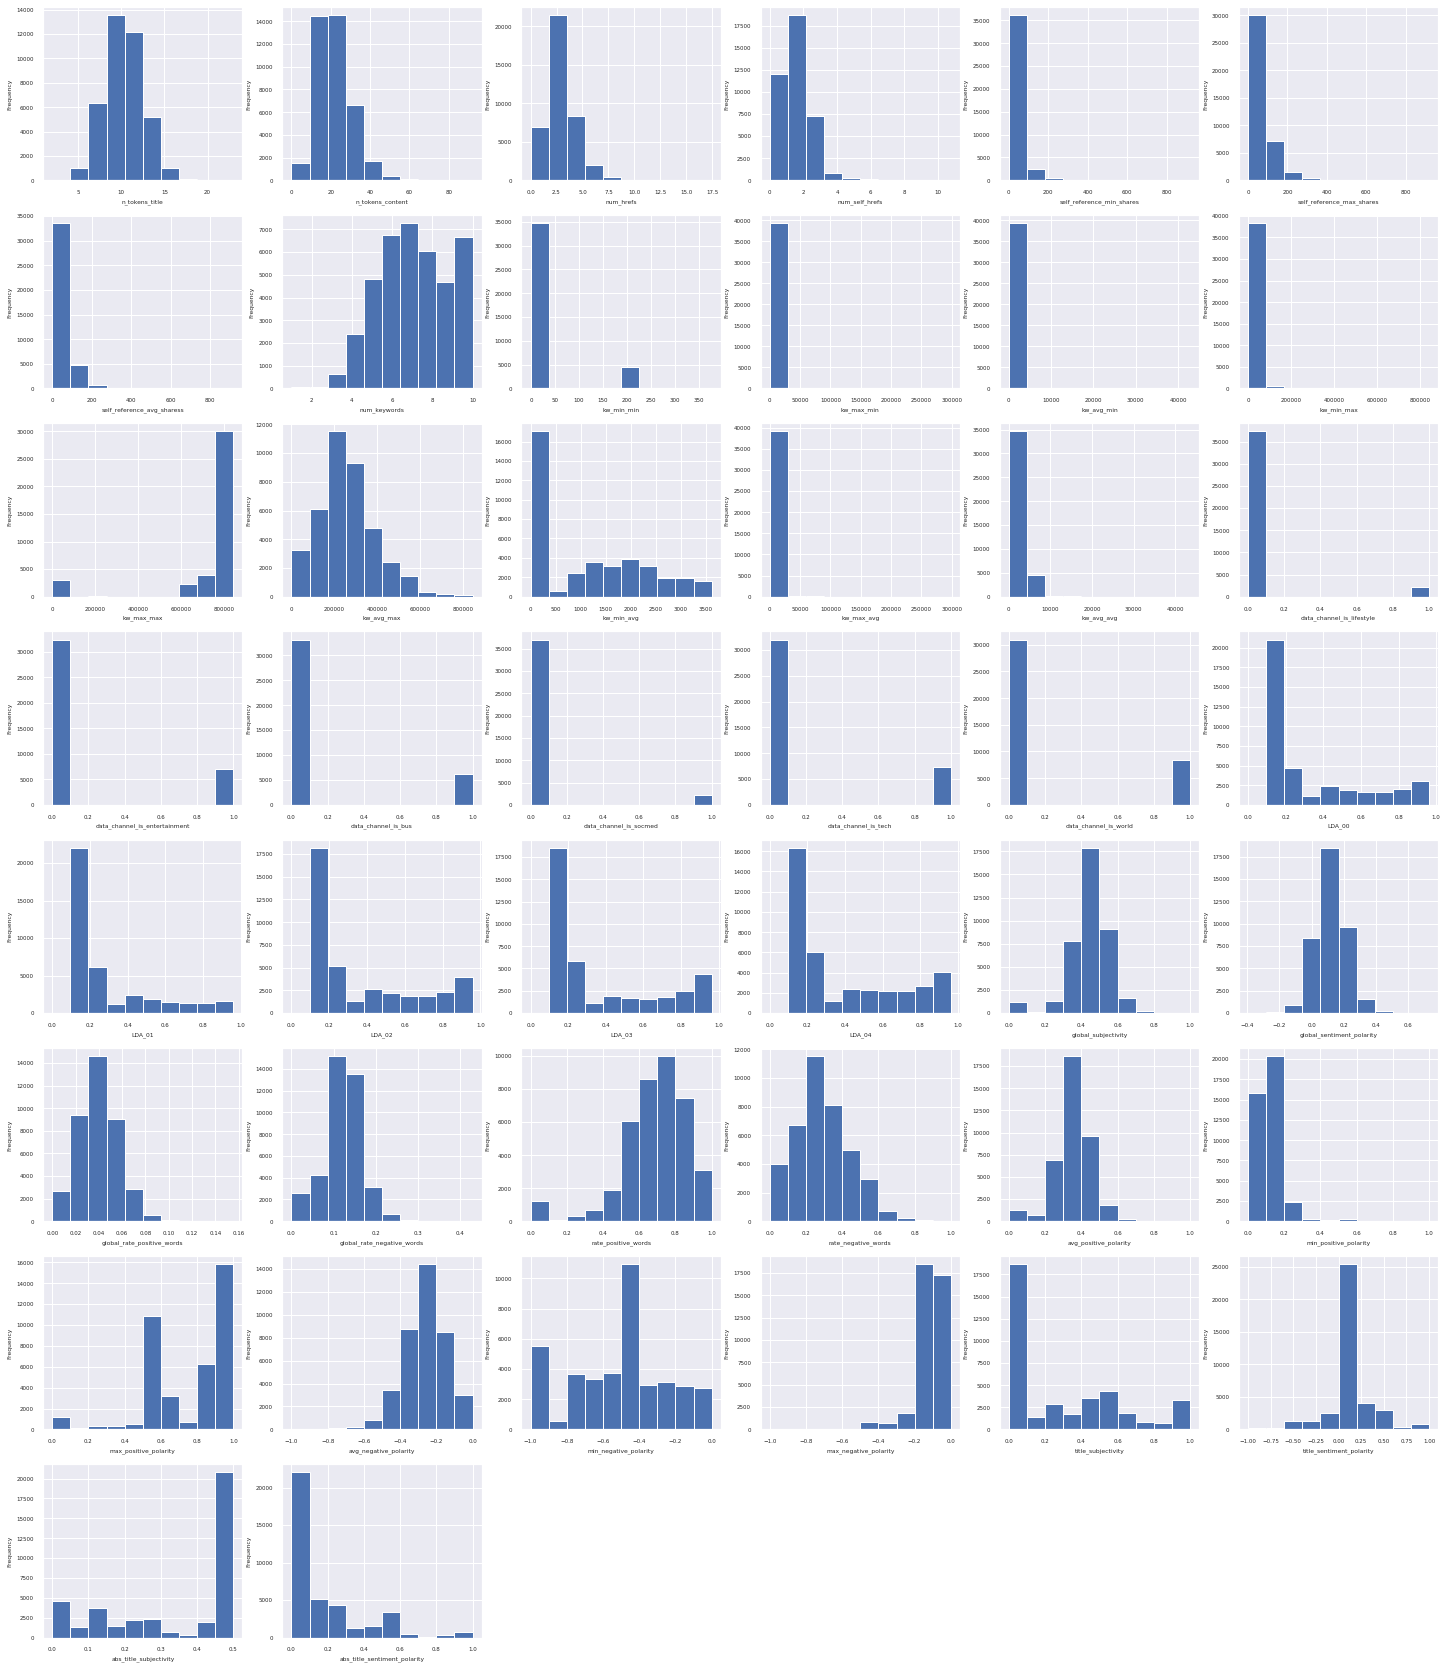

In [ ]:
# univariate analysis
fig = plt.figure(figsize=(25, 30))  
i = 0
for column in X:
    sub = fig.add_subplot(8, 6 , i + 1)
    sub.set_xlabel(column)
    X[column].plot(kind = 'hist')
    i = i + 1

Se ve que los features corregidos tienen ahora mas a la normalidad.

In [ ]:
features = [
    # 'timedelta', 
    # Words
    'n_tokens_title', 'n_tokens_content', 
    # 'average_token_length', 
    # 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs',
    # Digital Media
    # 'num_imgs', 'num_videos', 
    # Links
    'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 
    # Time
    # 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 
    # 'is_weekend', 
    # Keywords
    'num_keywords', 
    'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
    'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 
    # Natural Language Processing
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 
    'global_subjectivity', 'global_sentiment_polarity', 
    'global_rate_positive_words', 'global_rate_negative_words', 
    'rate_positive_words', 'rate_negative_words', 
    'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 
    'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

X = df[features]
y = df.shares

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)


# Funcion para comparar distintos modelos
def score_model(model, X_t=train_X, X_v=val_X, y_t=train_y, y_v=val_y):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds), mean_squared_error(y_v, preds)

models = [
    DecisionTreeRegressor(max_leaf_nodes=None, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=2, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=3, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=4, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=6, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=7, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=8, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=9, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=10, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=20, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=30, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=40, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=50, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=500, random_state=1),
    DecisionTreeRegressor(max_leaf_nodes=5000, random_state=1),
#     RandomForestRegressor(random_state=1)
#     RandomForestRegressor(n_estimators=50, random_state=1),
#     RandomForestRegressor(n_estimators=100, random_state=1),
#     # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=1),
#     # RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=1),
#     # RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1),
    XGBRegressor(), 
    XGBRegressor(n_estimators=500), 
    XGBRegressor(n_estimators=1000, learning_rate=0.05),
]

for i in range(0, len(models)):
    mae, mse = score_model(models[i])
    print("Model %d MAE: %d MSE: %d" % (i+1, mae, mse))

# Pruebo usando early stopping
my_model2 = XGBRegressor(n_estimators=500)
my_model2.fit(train_X, train_y,
              early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)
preds = my_model2.predict(val_X)
print("MAE: " + str(mean_absolute_error(preds, val_y)) + "MSE: " + str(mean_squared_error(preds, val_y)))

Model 1 MAE: 3070 MSE: 35895212
Model 2 MAE: 2178 MSE: 15209147
Model 3 MAE: 2158 MSE: 15083727
Model 4 MAE: 2153 MSE: 15024594
Model 5 MAE: 2154 MSE: 15052712
Model 6 MAE: 2145 MSE: 14984934
Model 7 MAE: 2140 MSE: 14979413
Model 8 MAE: 2136 MSE: 14941631
Model 9 MAE: 2134 MSE: 14934511
Model 10 MAE: 2138 MSE: 14999264
Model 11 MAE: 2140 MSE: 15213776
Model 12 MAE: 2148 MSE: 15671495
Model 13 MAE: 2157 MSE: 15984097
Model 14 MAE: 2154 MSE: 16000998
Model 15 MAE: 2348 MSE: 23843489
Model 16 MAE: 2952 MSE: 35118514
[03:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 17 MAE: 2088 MSE: 14679631
[03:26:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 18 MAE: 2096 MSE: 14842619
[03:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 19 MAE: 2097 MSE: 14845274
[

Con respecto a los valores anteriores:  
MAE: 2089.001336359132 MSE: 14674543.644854765  
Se logró un muy ligero empeoramiento:  
MAE: 2089.4773640152353MSE: 14678665.893902794  
Por lo que esta corrección parece no haber dado buen resultado.